# XGBoost Parameter Tuning for Rent Listing Inqueries

Rental Listing Inquiries数据集是Kaggle平台上的一个分类竞赛任务，需要根据公寓的特征来预测其受欢迎程度（用户感兴趣程度分为高、中、低三类）。其中房屋的特征x共有14维，响应值y为用户对该公寓的感兴趣程度。评价标准为logloss。 数据链接：https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries


6. 再次直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# 读取数据

In [2]:
train = pd.read_csv("RentListingInquries_FE_train.csv")

# 准备数据

In [3]:
y_train = train['interest_level']

train = train.drop([ "interest_level"], axis=1)
X_train = train

In [4]:
fold = StratifiedKFold(n_splits=5, shuffle= True, random_state=3)

改小此时学习率为0.02，调整弱分类数目

此前已经调好的参数： n_estimators：238 max_depth：6 min_child_weight:5 reg_alpha：1,reg_lambda：2


In [5]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
    xgb_param['num_class'] = 3
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss',nfold=cv_folds,early_stopping_rounds=early_stopping_rounds)
  
    cvresult.to_csv('6_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

   #Print model report:
    print('logloss of train is:', logloss)

In [6]:
xgb6 = XGBClassifier(
        learning_rate =0.02,
        n_estimators=2000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=6,
        min_child_weight=5,
        gamma=0,
        subsample = 0.5,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        reg_alpha = 1,
        reg_lambda = 2,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb6, X_train, y_train,cv_folds=fold)

logloss of train is: 0.47335384945762493


In [7]:
xgb6.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.02,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 1307,
 'nthread': 1,
 'objective': 'multi:softprob',
 'reg_alpha': 1,
 'reg_lambda': 2,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': 1,
 'subsample': 0.5}

/home/shnu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


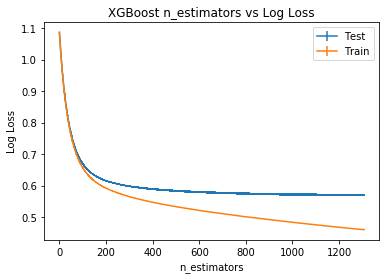

In [8]:
cvresult = pd.DataFrame.from_csv('6_nestimators.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.legend()
pyplot.savefig( 'n_estimators6.png' )

pyplot.show()

# 保存模型，供测试使用

In [9]:
#保存模型
import pickle
pickle.dump(xgb6, open("xgb_model.pkl", 'wb'))

In [10]:
#保存数据
import pickle

xgb = pickle.load(open("xgb_model.pkl", 'rb'))

train_predprob = xgb.predict_proba(X_train)
logloss = log_loss(y_train, train_predprob)

#Print model report:
print('logloss of train is:', logloss)

logloss of train is: 0.47335384945762493
